# Linear Models

There's a few linear models out there that we felt were generally useful. This
document will highlight some of them. 

## LOWESS

Lowess stands for LOcally WEighted regreSSion and has historically 
been used for smoothing but you can also use it
for machine learning where you're interested in interpolating. Here's 
a demo; 

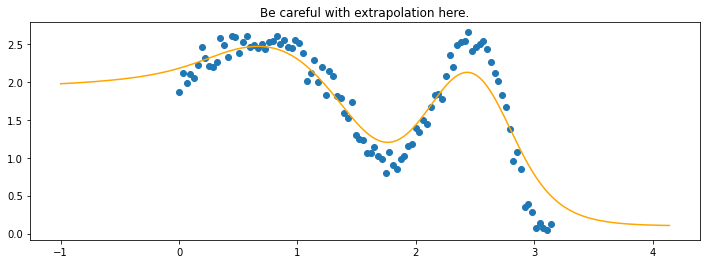

In [2]:
import numpy as np
import matplotlib.pylab as plt
from sklego.linear_model import LowessRegression

n = 100
xs = np.linspace(0, np.pi, n)
ys = 1 + np.sin(xs) + np.cos(xs**2) + np.random.normal(0, 0.1, n)

mod = LowessRegression(sigma=0.1, span=0.5).fit(xs.reshape(-1, 1), ys)

xs_new = np.linspace(-1, np.pi + 1, n*2)
preds = mod.predict(xs_new.reshape(-1, 1))

plt.figure(figsize=(12, 4))
plt.scatter(xs, ys)
plt.plot(xs_new, preds, color='orange')
plt.title("Be careful with extrapolation here.");

The line does not look linear but that's because internally, during prediction,
many weighted linear regressions are happening. The gif below demonstrates how 
the data is being weighted when we would make a prediction. 

![](_static/lowess-rolling.gif)

### Details on `sigma`.

We'll also show two different prediction outcomes depending on the hyperparameter
`sigma`. 

![](_static/lowess-pred-1.gif)
![](_static/lowess-pred-2.gif)

You may be tempted now to think that a lower sigma always has a better fit, but you
need to be careful here. The data might have gaps and larger sigma values will be
able to properly regularize.

![](_static/lowess-two-predictions.gif)

Note that this regression also works in higher dimensions but the main downside of 
this approach is that it is really slow when making predictions. 

If you really want to get advanced there's also a hyperparameter `span` but you'll
really need to know what you're doing. It was added for completeness but the authors 
of this package have yet to find a proper usecase for it. 

### Details on `span`.

The `span` parameter can be used to force that you'll only include a certain
  percentage of your dataset. Technically without a `span` you are still using
  all the data in your dataset, albeit with small weights if they are far away.
  
The effect of the `span` parameter on the weights can be seen below.

![](_static/lowess-span-1.png)
  
This will also effect the predictions.</p>

![](_static/lowess-span-2.png)

You may need to squint your eyes a bit to see it, but lower spans cause more 
  jiggles and less smooth curves.

## ProbWeightRegression

> Note, this is a somewhat experimental feature. We found this feature to be plausibly useful but we've not seen it cause a big "win" yet. 

Let's say that you're interested in combining a few models for a regression task. 
You could put them together in an ensemble. Say we've got predictions $y_1, y_2, y_3$, each of which come from respectable models, then you may want to combine these together in another linear regression. This way the new, hopefully best, prediction $y_*$ is defined via;

$$y^* = w_1 y_1 + w_2 y_2 + w_3 y_3$$ 

This can be a valid way of reweighing. But there's one issue:
technically the weights $w_1, w_2, w_3$ can sum to a number that isn't one. Since that's 
numerically totally possible we need to be aware that we can end up in a strange situation. 

The `ProbWeightRegression` adresses this. It assumes that every input it receives is
the output of a model and it will ensure that they are reweighed with a constraint in mind. For this usecase, it would optimise;

\begin{equation} \label{eq1}
\begin{split}
\text{min} & \sum_i (y_i - (w_1 y_{1,i} + w_2 y_{2,i} + w_3 y_{3,i}))^2 \\
\text{subject to} & \\
& \text{ } w_1 + w_2 + w_3 = 1 \\ 
& \text{ } w_1 \geq 0, w_2 \geq 0, w_3 \geq 0
\end{split}
\end{equation}

The final positivity constraint is optional in our model. 

Here's an example usage.

In [3]:
from sklearn.datasets import make_regression
import pandas as pd

X, y = make_regression(n_samples=1000, n_features=10, random_state=42)
df = pd.DataFrame(X)

We've turned the array into a dataframe so that we can apply the `ColumnSelector`.

In [6]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklego.meta import EstimatorTransformer
from sklego.linear_model import ProbWeightRegression
from sklego.preprocessing import ColumnSelector

pipe = Pipeline([
    ('models', FeatureUnion([
        ('path1', Pipeline([
            ('select1', ColumnSelector([0,1,2,3,4])),
            ('pca', PCA(n_components=3)),
            ('linear', EstimatorTransformer(LinearRegression()))
        ])),
        ('path2', Pipeline([
            ('select2', ColumnSelector([5,6,7,8,9])),
            ('pca', PCA(n_components=2)),
            ('linear', EstimatorTransformer(LinearRegression()))
        ]))
    ])),
    ('prob_weight', ProbWeightRegression())
])

grid = GridSearchCV(estimator=pipe, param_grid={}, cv=3).fit(df, y)

In [7]:
from sklearn import set_config
set_config(display='diagram')
grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('models',
                                        FeatureUnion(transformer_list=[('path1',
                                                                        Pipeline(steps=[('select1',
                                                                                         ColumnSelector(columns=[0,
                                                                                                                 1,
                                                                                                                 2,
                                                                                                                 3,
                                                                                                                 4])),
                                                                                        ('pca',
                                                                                         PCA(n_components=3)),
                                                                                        ('linear',
                                                                                         EstimatorTransformer(estimator=LinearRegression()))])),
                                                                       ('path2',
                                                                        Pipeline(steps=[('select2',
                                                                                         ColumnSelector(columns=[5,
                                                                                                                 6,
                                                                                                                 7,
                                                                                                                 8,
                                                                                                                 9])),
                                                                                        ('pca',
                                                                                         PCA(n_components=2)),
                                                                                        ('linear',
                                                                                         EstimatorTransformer(estimator=LinearRegression()))]))])),
                                       ('prob_weight',
                                        ProbWeightRegression())]),
             param_grid={})

You can see that the `ProbWeightRegression` indeeds sums to one. 

In [8]:
grid.best_estimator_[1].coefs_

array([0.03102466, 0.96897535])

## Least Absolute Deviation Regression

Imagine that you have a dataset with some outliers.

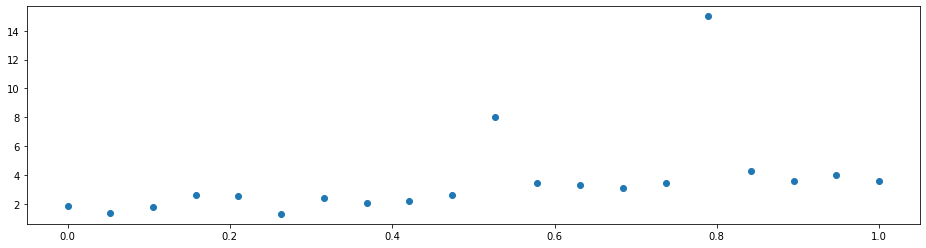

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
X = np.linspace(0, 1, 20)
y = 3*X + 1 + 0.5*np.random.randn(20)
X = X.reshape(-1, 1)

y[10] = 8
y[15] = 15

plt.figure(figsize=(16, 4))
plt.scatter(X, y)

A simple linear regression will not do a good job since it is distracted by the outliers. That is because it optimizes the mean squared error
$$ \sum_i \left(y_i-\textrm{model}(x_i)\right)^2 $$

which penalizes a few large errors more than many tiny errors. For example, if y-model(x) = 4 for some single observation, the MSE here is 16. If there are two observations with y_1 - model(x_1) = 2 and y_2 - model(x_2) = 2, the MSE is 8 in total, which is less than for one larger error. Note that the sum of the errors is the same in both cases.

Hence, linear regression does the following:

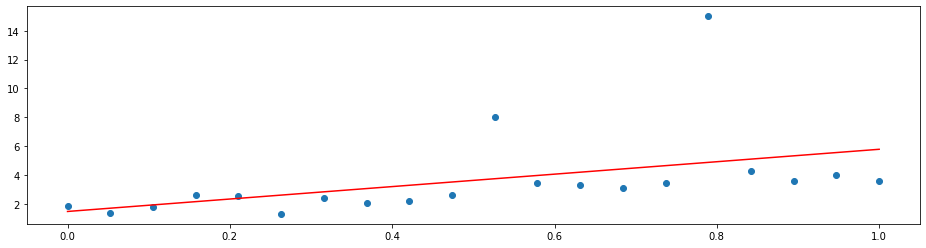

In [7]:
from sklearn.linear_model import LinearRegression

x = np.array([0, 1]).reshape(-1, 1)
plt.figure(figsize=(16, 4))
plt.scatter(X, y)
plt.plot(x, LinearRegression().fit(X, y).predict(x), 'r')

By changing the loss function to the mean absolute deviation 
$$ \sum_i \left|y_i-\textrm{model}(x_i)\right|\enspace, $$

we can let the model put the same focus on each error. This yields the least absolute deviation (LAD) regression that tries to agree with the majority of the points.

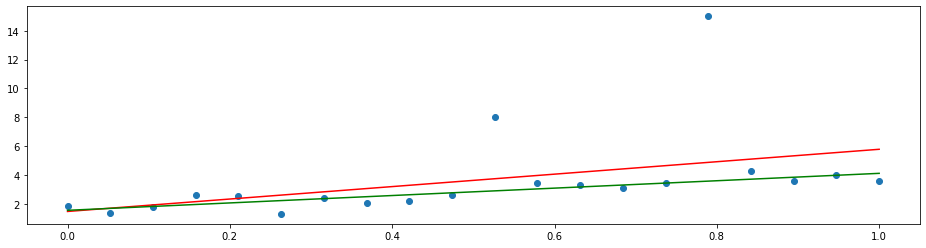

In [8]:
from sklearn.linear_model import LinearRegression
from sklego.linear_model import LADRegression

x = np.array([0, 1]).reshape(-1, 1)
plt.figure(figsize=(16, 4))
plt.scatter(X, y)
plt.plot(x, LinearRegression().fit(X, y).predict(x), 'r')
plt.plot(x, LADRegression().fit(X, y).predict(x), 'g')

### See also
scikit-learn tackles this problem by offering a variety of [robust regressors](https://scikit-learn.org/stable/auto_examples/linear_model/plot_robust_fit.html). Many of them use an indirect approach to reduce the effect of outliers. [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus), for example, samples random points from the dataset until it consists of all inliers.
The closest thing to LADRegression that scikit-learn offers is the [HuberRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html) with a loss function that is partly a squared and partly an absolute error. However, it is more complicated and requires hyperparameter tuning to unleash its full potential.
